In [0]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

import functools
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras import backend
from tensorflow.python.keras import layers

import numpy as np

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  1.15.0


In [3]:
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Importing all necessary keras Modules
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
import cProfile, pstats, io

In [8]:
# Download the CIFAR10 dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


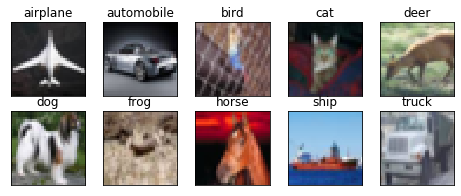

In [9]:
# Visualization of images from dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Function defined for plotting the model history i.e epoch vs validation accuracy & epoch vs validation loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# As shown above the label matrix(train_features & test_features) holds the images. So, keras may find some relational order
# between these values. To avoid this problem we hot encode the matrix into a binary matrix. This matrix has number of columns equal to the number
# of classes(10 columns in this scenario). Each row defines the label of one sample point in data set & has only one '1' & others are '0'.
# Convert 1-dimensional class arrays to 10-dimensional class matrices
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Defined function for learning rate schedule
def scheduler(epoch,lr):
  decay = 0.1
  return round(0.01 * 1/(1 + decay * epoch) , 10)

In [14]:
# Define the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(32, 1, 1, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3 , border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(10, 1, 1, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(10, 8, 8))

model.add(Flatten())

model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer=Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  app.launch_new_instance()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8))`


In [15]:
# summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)      

In [0]:
log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, profile_batch = 3)

In [0]:
# checkpoint. Saves the best model
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint , LearningRateScheduler(scheduler,verbose = 1) , tensorboard_callback]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys




Train on 50000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
  768/50000 [..............................] - ETA: 7:01 - loss: 3.3265 - acc: 0.1302 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


50000/50000 [==============================] - 25s 493us/step - loss: 1.5248 - acc: 0.4598 - val_loss: 1.5457 - val_acc: 0.4702

Epoch 00001: val_acc improved from -inf to 0.47020, saving model to weights.best.hdf5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0090909091.
50000/50000 [==============================] - 18s 357us/step - loss: 1.0790 - acc: 0.6206 - val_loss: 1.0055 - val_acc: 0.6443

Epoch 00002: val_acc improved from 0.47020 to 0.64430, saving model to weights.best.hdf5
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0083333333.
50000/50000 [==============================] - 18s 360us/step - loss: 0.8621 - acc: 0.6986 - val_loss: 1.1657 - val_acc: 0.6091

Epoch 00003: val_acc did not improve from 0.64430
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0076923077.
50000/50000 [==============================] - 18s 364us/step - loss: 0.7411 - acc: 0.7406 - val_loss: 1.0795 - val_acc: 0.6469

E

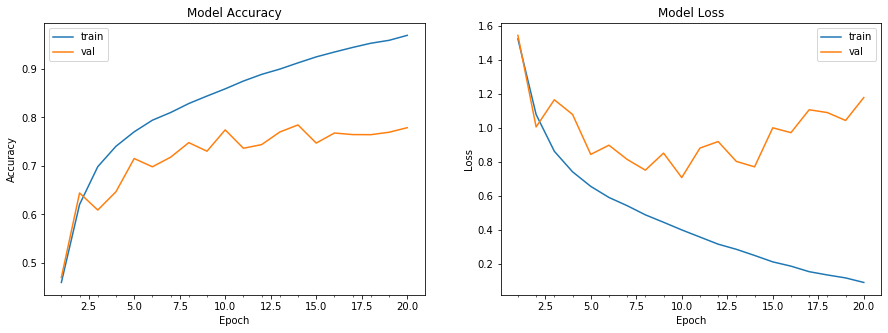

Accuracy on test data is: 77.89


In [19]:
# train the model
start = time.time()
# Train the model. Using cProfile to capture all the processes during training.
pr = cProfile.Profile()
pr.enable()
model_info = model.fit(train_features, train_labels, batch_size = 128,
                                 nb_epoch = 20, 
                                 validation_data = (test_features,test_labels), callbacks = callbacks_list)
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [20]:
# Evaluate the model on weights saved for the best model
score = model.evaluate(test_features, test_labels, verbose = 1)

10000/10000 [==============================] - 2s 166us/step


In [21]:
# Loss & accuracy on test set
print(score)

[1.1787795497179032, 0.7789]


In [19]:
# Compress the profiler log file.
!tar -zcvf logs.tar.gz logs/profile/

logs/profile/
logs/profile/20191113-184728/
logs/profile/20191113-184728/events.out.tfevents.1573670852.148bedcca1b9
logs/profile/20191113-184728/events.out.tfevents.1573670880.148bedcca1b9
logs/profile/20191113-184728/events.out.tfevents.1573670857.148bedcca1b9.profile-empty
logs/profile/20191113-184728/plugins/
logs/profile/20191113-184728/plugins/profile/
logs/profile/20191113-184728/plugins/profile/2019-11-13_18-47-37/
logs/profile/20191113-184728/plugins/profile/2019-11-13_18-47-37/local.trace
